# **Importing the Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU, Concatenate, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Conv1D, MaxPool1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

2024-06-22 06:49:20.413412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 06:49:20.413516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 06:49:20.567229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import random

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '21'
random.seed(21)
np.random.seed(21)
tf.random.set_seed(21)

# **Reading the dataset**

In [5]:
df = pd.read_csv('/kaggle/input/cloud-coverage-dataset/CCD DATA SET/train.csv')
df = df.dropna(how='all')
df.head()

/tmp/ipykernel_34/4177980373.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/cloud-coverage-dataset/CCD DATA SET/train.csv')


,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,01-Jan,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,01-Jan,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,01-Jan,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,01-Jan,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,01-Jan,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0


# **Sorting the dataset on the basis of Dates**

In [6]:
def get_date(date):
    date = date + "-2020"
    try:
        return datetime.strptime(date, "%d-%b-%Y").date()
    
    except ValueError:
        return datetime.strptime(date, "%b-%d-%Y").date()

In [7]:
df['Date'] = df['DATE (MM/DD)'].apply(get_date).astype('datetime64[ns]')

In [8]:
df['Time'] = pd.to_timedelta(df['MST'] + ':00')

In [9]:
df['Datetime'] = df['Date'].dt.dayofyear.astype('timedelta64[D]') + df['Time']

In [10]:
df = df.sort_values(by='Datetime')
df.reset_index(drop=True, inplace=True)

In [11]:
df.drop(['DATE (MM/DD)', 'MST'], axis=1, inplace=True)

In [12]:
df.head()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11),Date,Time,Datetime
0,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01,0 days 00:00:00,1 days 00:00:00
1,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01,0 days 00:01:00,1 days 00:01:00
2,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01,0 days 00:02:00,1 days 00:02:00
3,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0,2020-01-01,0 days 00:03:00,1 days 00:03:00
4,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0,2020-01-01,0 days 00:04:00,1 days 00:04:00


# **Data Analysis / Visualization**

In [13]:
df.isna().sum()

Global CMP22 (vent/cor) [W/m^2]             0
Direct sNIP [W/m^2]                         0
Azimuth Angle [degrees]                     0
Tower Dry Bulb Temp [deg C]                 0
Tower Wet Bulb Temp [deg C]                 0
Tower Dew Point Temp [deg C]                0
Tower RH [%]                                0
Total Cloud Cover [%]                    1469
Peak Wind Speed @ 6ft [m/s]                 0
Avg Wind Direction @ 6ft [deg from N]       0
Station Pressure [mBar]                     0
Precipitation (Accumulated) [mm]            0
Snow Depth [cm]                             0
Moisture                                    0
Albedo (CMP11)                              0
Date                                        0
Time                                        0
Datetime                                    0
dtype: int64

### ***Visualizing the Distribution Curves***

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Total Cloud Cover [%]', ylabel='Density'>

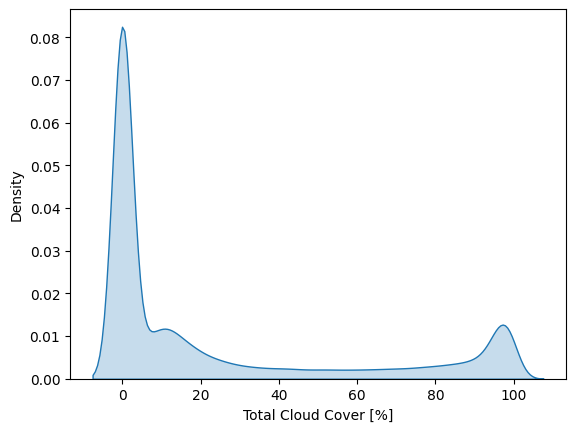

In [16]:
sb.kdeplot(df['Total Cloud Cover [%]'], fill=True)

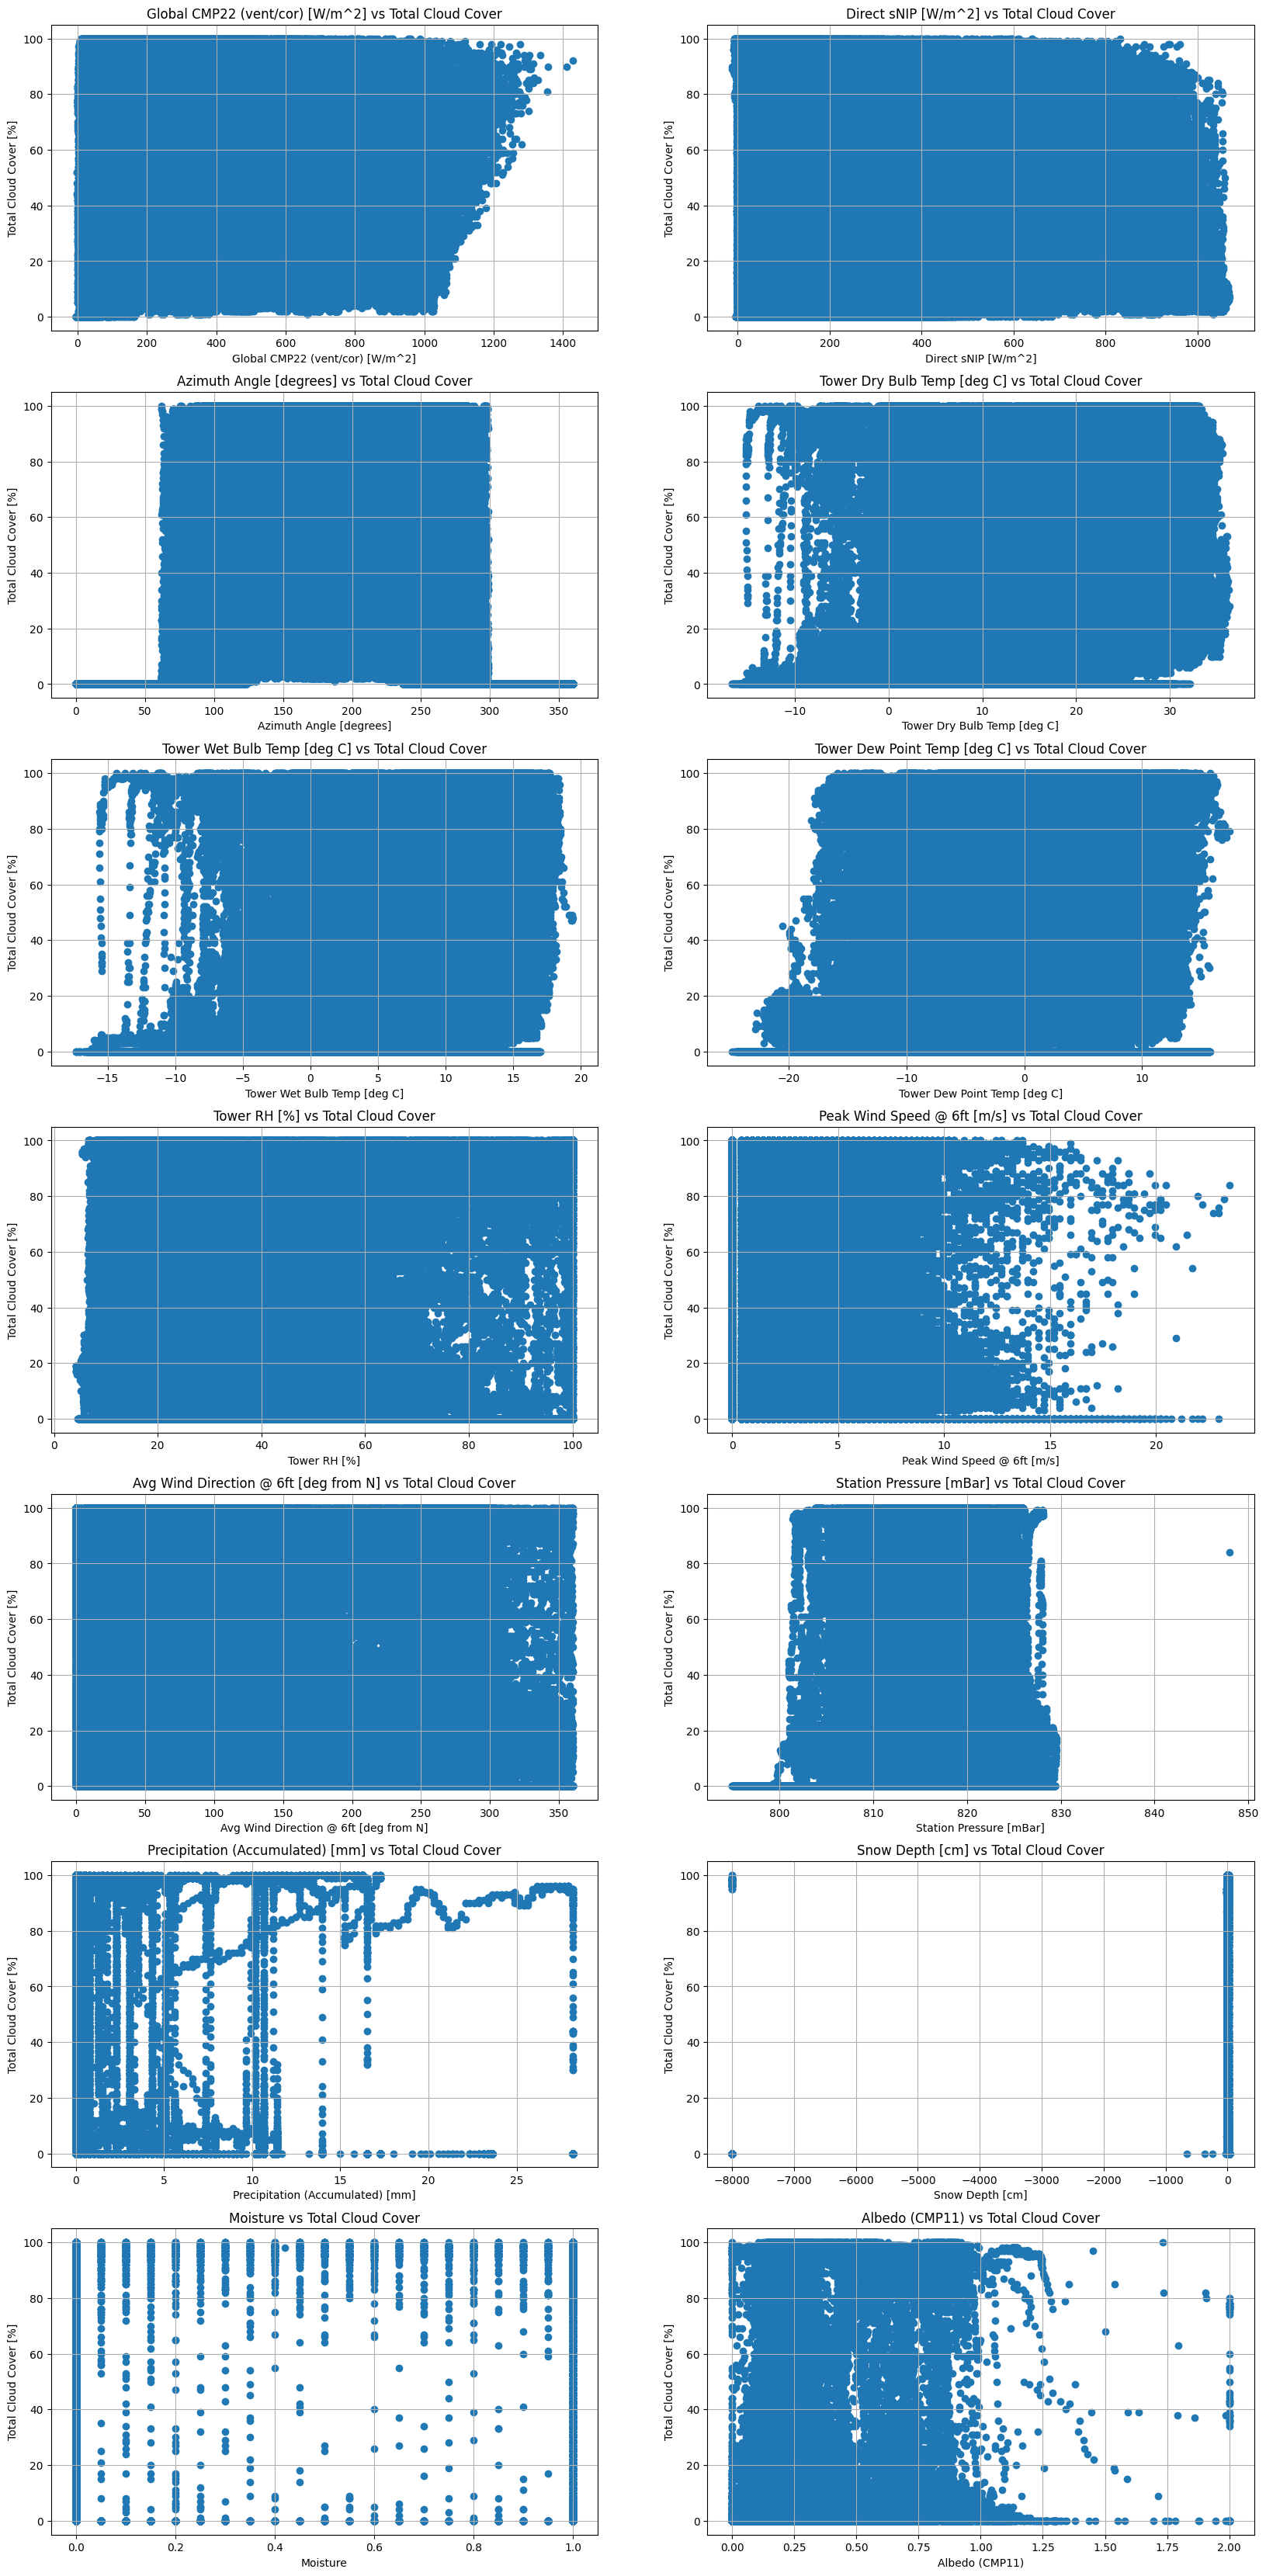

In [13]:
fig, ax = plt.subplots(7, 2, figsize=(20,42))
ax = ax.flatten()

cols = df.drop(['Total Cloud Cover [%]', 'Date', 'Time', 'Datetime'], axis=1).columns.tolist()

for ind, col in enumerate(cols):
    ax[ind].scatter(df[col], df['Total Cloud Cover [%]'])
    ax[ind].set_title(f'{col} vs Total Cloud Cover')
    ax[ind].set_xlabel(col)
    ax[ind].set_ylabel('Total Cloud Cover [%]')
    ax[ind].grid(True)

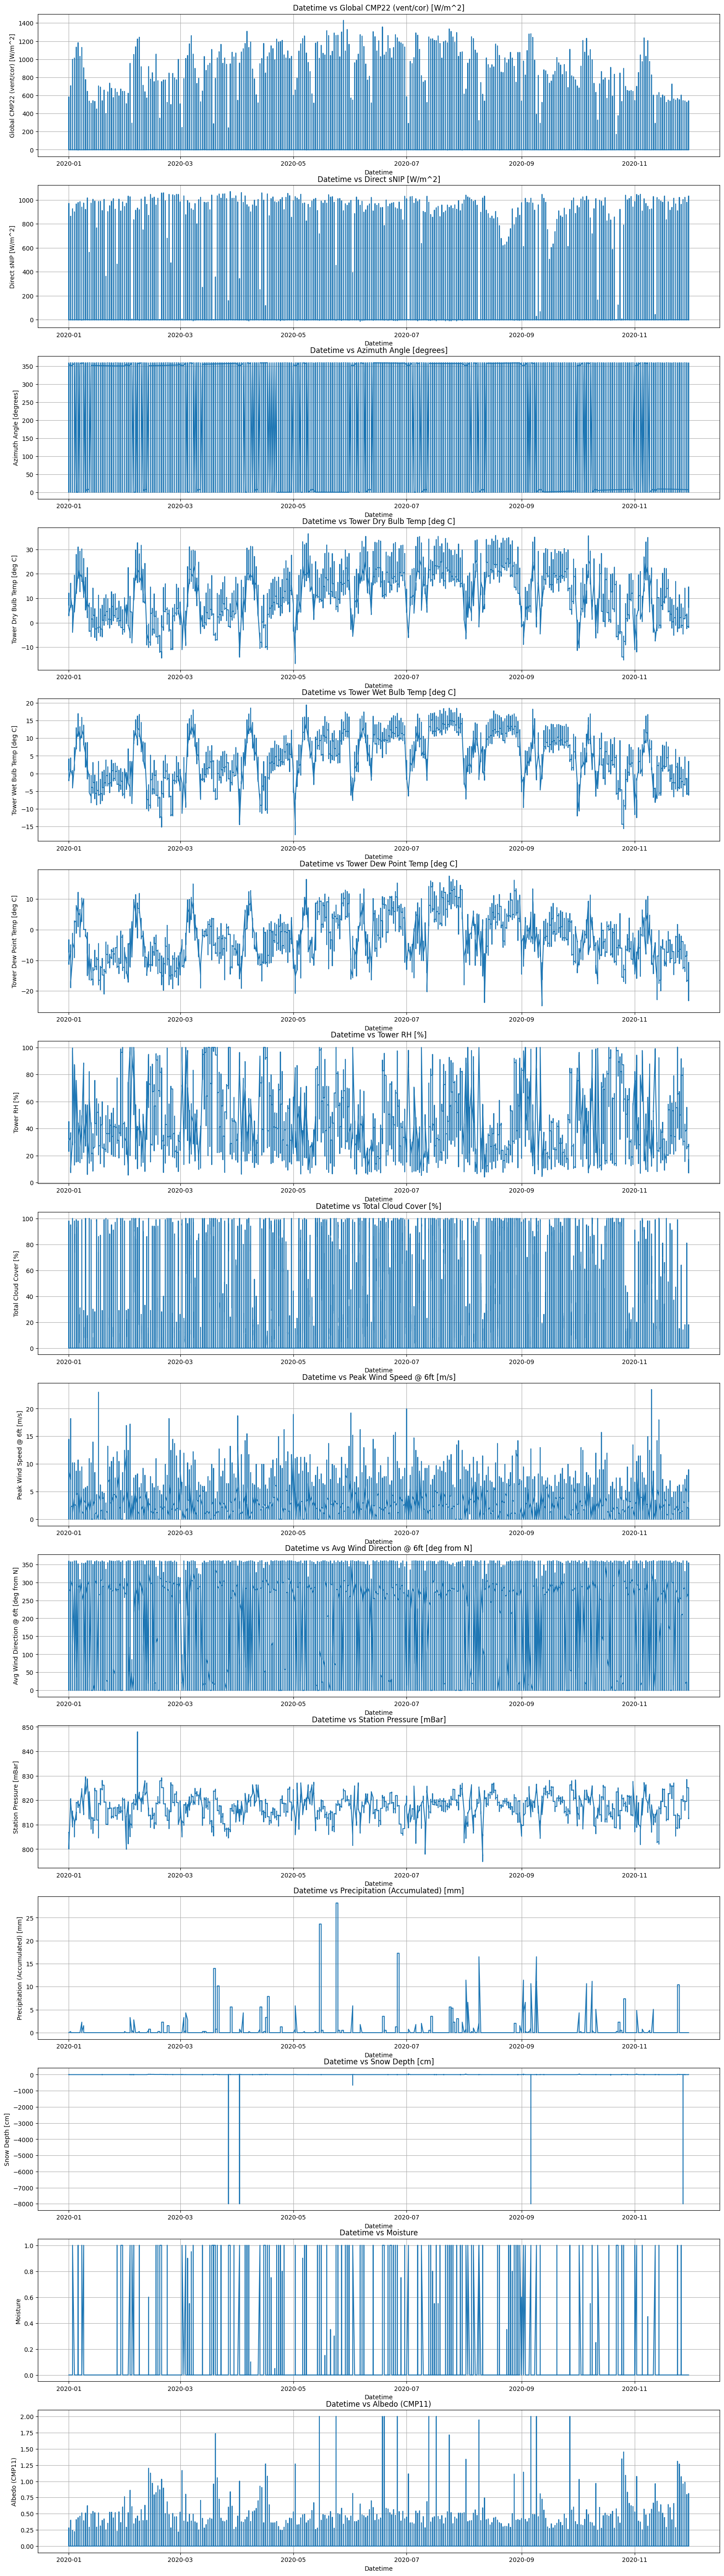

In [14]:
fig, ax = plt.subplots(15, 1, figsize=(20,75))
ax = ax.flatten()

cols = df.drop(['Date', 'Time', 'Datetime'], axis=1).columns.tolist()

for ind, col in enumerate(cols):
    ax[ind].plot(df['Date'], df[col])
    ax[ind].set_title(f'Datetime vs {col}')
    ax[ind].set_ylabel(col)
    ax[ind].set_xlabel('Datetime')
    ax[ind].grid(True)

### ***Plotting the correlation matrix***

In [13]:
corr_mat = df.corr()

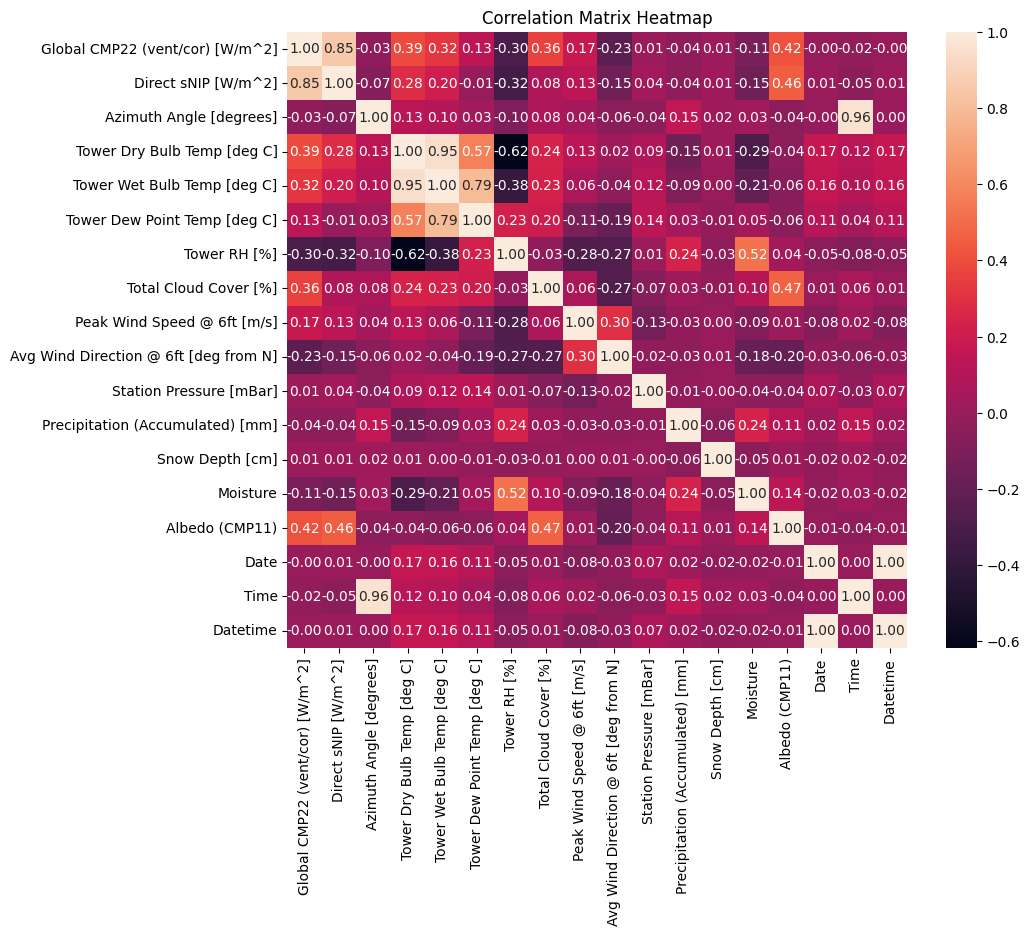

In [14]:
plt.figure(figsize=(10, 8))

sb.heatmap(corr_mat, annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

# **Feature Engineering**

### ***Categorizing Wind Direction***

In [14]:
def get_wind_direction(degrees):
    if degrees >= 337.5 or degrees < 22.5:
        return 'North'
    elif 22.5 <= degrees < 67.5:
        return 'North-East'
    elif 67.5 <= degrees < 112.5:
        return 'East'
    elif 112.5 <= degrees < 157.5:
        return 'South-East'
    elif 157.5 <= degrees < 202.5:
        return 'South'
    elif 202.5 <= degrees < 247.5:
        return 'South-West'
    elif 247.5 <= degrees < 292.5:
        return 'West'
    elif 292.5 <= degrees < 337.5:
        return 'North-West'

In [15]:
df['Wind Direction'] = df['Avg Wind Direction @ 6ft [deg from N]'].apply(get_wind_direction)

df['Wind Direction'] = df['Wind Direction'].map({'North': 0, 'North-East': 1, 'East': 2, 'South-East': 3, 'South': 4, 'South-West': 5, 'West': 6, 'North-West': 7})

### ***Mean Wind Speed over 5 minutes***

In [16]:
df['Avg. Wind Speed'] = df['Peak Wind Speed @ 6ft [m/s]'].rolling(window=5).mean()

In [17]:
for i in range(4):
    df.loc[i, 'Avg. Wind Speed'] = df.loc[:i, 'Peak Wind Speed @ 6ft [m/s]'].mean()

### ***Mean Temperature of the past hour***

In [18]:
df['Avg. Tower Temp'] = df['Tower Dew Point Temp [deg C]'].rolling(window=60).mean()

In [19]:
for i in range(60):
    df.loc[i, 'Avg. Tower Temp'] = df.loc[:i, 'Tower Dew Point Temp [deg C]'].mean()

### ***Calculating Humidity***

In [20]:
df['Humidity_Temp_Interaction'] = df['Tower RH [%]'] * df['Tower Dry Bulb Temp [deg C]']

### ***Calculating Air Density***

In [21]:
R = 287.058
df['Air_Density'] = (df['Station Pressure [mBar]'] * 100) / (R * (df['Tower Dry Bulb Temp [deg C]'] + 273.15))

### ***Calculating Saturation Vapour Pressure***

In [22]:
df['Saturation_Vapor_Pressure'] = 6.11 * 10 ** ((7.5 * df['Tower Dry Bulb Temp [deg C]']) / (237.3 + df['Tower Dry Bulb Temp [deg C]']))

### ***Calculating Vapour Pressure***

In [23]:
df['Vapor_Pressure'] = (df['Tower RH [%]'] / 100) * df['Saturation_Vapor_Pressure']

### ***Finalizing the Columns***

In [24]:
cols = ['Total Cloud Cover [%]', 'Date', 'Time', 'Datetime']

col_train = df.drop(cols, axis=1).columns.tolist()
col_train

['Global CMP22 (vent/cor) [W/m^2]',
 'Direct sNIP [W/m^2]',
 'Azimuth Angle [degrees]',
 'Tower Dry Bulb Temp [deg C]',
 'Tower Wet Bulb Temp [deg C]',
 'Tower Dew Point Temp [deg C]',
 'Tower RH [%]',
 'Peak Wind Speed @ 6ft [m/s]',
 'Avg Wind Direction @ 6ft [deg from N]',
 'Station Pressure [mBar]',
 'Precipitation (Accumulated) [mm]',
 'Snow Depth [cm]',
 'Moisture',
 'Albedo (CMP11)',
 'Wind Direction',
 'Avg. Wind Speed',
 'Avg. Tower Temp',
 'Humidity_Temp_Interaction',
 'Air_Density',
 'Saturation_Vapor_Pressure',
 'Vapor_Pressure']

# **Data Preprocessing**

### ***Filling null values in Total Cloud Cover by linear interpolation***

In [25]:
df['Total Cloud Cover [%]'] = df['Total Cloud Cover [%]'].interpolate(method='linear')

In [26]:
df['Total Cloud Cover [%]'] = df['Total Cloud Cover [%]'].apply(round)

### ***Scaling the features to (0,1)***

In [27]:
scaler = MinMaxScaler()

In [28]:
scaled_features = scaler.fit_transform(df[col_train])

### ***Creating the training and testing dataset***

In [29]:
sequence_length = 120
future_steps = [15, 25, 30]

In [30]:
x, y = [], []

for i in range(sequence_length, len(scaled_features) - max(future_steps)):
    x.append(scaled_features[i-sequence_length:i])
    
    arr = []
    arr.append(df['Total Cloud Cover [%]'].iloc[i + future_steps[0]])
    arr.append(df['Total Cloud Cover [%]'].iloc[i + future_steps[1]])
    arr.append(df['Total Cloud Cover [%]'].iloc[i + future_steps[2]])
    
    y.append(arr)
    
x = np.asarray(x)
y = np.asarray(y)

In [31]:
print(x.shape)
print(y.shape)

(482250, 120, 21)
(482250, 3)


In [32]:
x_train = x[:int(len(x)*0.8), :, :]
x_test = x[int(len(x)*0.8): , :, :]

y_train = y[:int(len(y)*0.8), :]
y_test = y[int(len(y)*0.8):, :]

# **Creating the Model Architecture**

### ***Stacked LSTM***

In [32]:
def lstm_model(input_shape, output_shape):
    model = Sequential([
        Input(shape = input_shape),
        
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        
        Dense(output_shape)
    ], name='LSTM')
    
    return model

### ***GRU + LSTM***

In [33]:
def gru_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    
    #block 1
    lstm1 = LSTM(64, return_sequences=True)(inputs)
    gru1 = GRU(64, return_sequences=True)(inputs)
    
    #block 2
    concat = Concatenate()([lstm1, gru1])
    layer = Dense(32, activation='relu')(concat)
    
    #block 3
    lstm2 = LSTM(32, return_sequences=True)(layer)
    gru2 = GRU(32, return_sequences=True)(layer)
    
    #block 4
    concat = Concatenate()([lstm2, gru2])
    layer = Dense(16, activation='relu')(concat)
    
    #block 5
    lstm3 = LSTM(16, return_sequences=False)(layer)
    gru3 = GRU(16, return_sequences=False)(layer)
    
    #block 6
    concat = Concatenate()([lstm3, gru3])
    layer = Dense(8, activation='relu')(concat)
    
    #block 7
    out = Dense(output_shape, activation='relu')(layer)
    
    model = Model(inputs=inputs, outputs=out, name='GRU_LSTM')
    
    return model

### ***Transformer***

In [33]:
def encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Layers
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

In [35]:
def transformer(input_shape, output_shape):
    num_transformer_blocks=2
    mlp_units=[128]
    
    inputs = Input(shape=input_shape)
    
    layer = encoder(inputs, head_size=256, num_heads=4, ff_dim=8, dropout=0.2)
    
    # Encoder Blocks
    for _ in range(num_transformer_blocks-1):
        layer = encoder(layer, head_size=256, num_heads=4, ff_dim=8, dropout=0.2)

    layer = GlobalAveragePooling1D(data_format="channels_first")(layer)
    
    # Multi-Layer Perceptron Layers
    for dim in mlp_units:
        layer = Dense(dim, activation="relu")(layer)
        layer = Dropout(0.2)(layer)
    
    out = Dense(output_shape)(layer)
    
    model = Model(inputs=inputs, outputs=out, name='Transformer')
    
    return model

### ***TDNN***

In [36]:
def conv_block(_input, num_filters:int):
    x1 = Conv1D(filters=num_filters, kernel_size=1, activation=tf.nn.tanh, padding="same", kernel_regularizer='l1')(_input)
    x2 = Conv1D(filters=num_filters, kernel_size=3, activation=tf.nn.tanh, padding="same", kernel_regularizer='l1')(_input)
    x3 = Conv1D(filters=num_filters, kernel_size=5, activation=tf.nn.tanh, padding="same", kernel_regularizer='l1')(_input)
    
    output = Concatenate()([x1,x2,x3])
    return output

In [37]:
def tdnn(input_shape, output_shape):
    _inputs = tf.keras.Input(shape=input_shape)
    
    x = conv_block(_inputs, 32)
    x = Dropout(0.3)(x)
    
    x = conv_block(x, 16)
    x = Flatten()(x)
    
    x = Dense(32, activation=tf.nn.gelu)(x)
    x = Dense(32, activation=tf.nn.gelu)(x)
    x = Dropout(0.3)(x)
    
    x = Dense(16, activation=tf.nn.tanh)(x)
    _outputs = Dense(output_shape)(x)
    
    model = tf.keras.models.Model(_inputs, _outputs)
    return model

# **Custom Loss Functions**

### ***Penalty Function***

In [36]:
def add_penalty(y_true, y_pred, threshold=3, penalty_weight=3.0):
    abs_diff = tf.abs(y_true - y_pred)
    
    penalty_condition = tf.logical_and(y_true != 0, abs_diff > threshold)
    penalty = tf.where(penalty_condition, penalty_weight, 1.0)
    
    return tf.cast(penalty, dtype=tf.float32)

### ***Custom MAE Loss***

In [37]:
class MAE_Loss(tf.keras.losses.Loss):
    def __init__(self, threshold=3.0, penalty_weight=3.0):
        super().__init__()
        self.threshold = threshold
        self.penalty_weight = penalty_weight
        
    def call(self, y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        penalty = add_penalty(y_true, y_pred, self.threshold, self.penalty_weight)
        weighted_diff = diff * penalty
        return tf.reduce_mean(weighted_diff)

### ***Custom MSE Loss***

In [38]:
class MSE_Loss(tf.keras.losses.Loss):
    def __init__(self, threshold=3.0, penalty_weight=3.0):
        super().__init__()
        self.threshold = threshold
        self.penalty_weight = penalty_weight
        
    def call(self, y_true, y_pred):
        diff = tf.square(y_true - y_pred)
        penalty = add_penalty(y_true, y_pred, self.threshold, self.penalty_weight)
        weighted_diff = diff * penalty
        return tf.reduce_mean(weighted_diff)

# **Training the Model**

In [39]:
input_shape = x_train.shape[-2:]
output_shape = len(future_steps)

In [40]:
stop_early = EarlyStopping(
    monitor = 'val_r2_score',
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)

### ***LSTM Model***

In [49]:
lstm = lstm_model(input_shape, output_shape)
lstm.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 120, 128)       │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,203 (543.76 KB)

 Trainable params: 139,203 (543.76 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
lstm.compile(
    optimizer = 'adam',
    loss = MAE_Loss(threshold=3.0, penalty_weight=2.0),
    metrics = [
        "mse",
        "r2_score",
        "mae"
    ]
)

In [42]:
history = lstm.fit(
    x_train,
    y_train,
    epochs = 20,
    batch_size = 128,
    validation_data = (x_test, y_test),
    callbacks = stop_early
)

Epoch 1/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 76s 21ms/step - loss: 39.6871 - mae: 22.0446 - mse: 1159.5012 - r2_score: 0.0798 - val_loss: 8.9901 - val_mae: 4.7240 - val_mse: 157.4217 - val_r2_score: 0.7503
Epoch 2/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 68s 20ms/step - loss: 13.5437 - mae: 7.1171 - mse: 232.9378 - r2_score: 0.8149 - val_loss: 8.9121 - val_mae: 4.8436 - val_mse: 166.8378 - val_r2_score: 0.7353
Epoch 3/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 68s 20ms/step - loss: 12.4498 - mae: 6.5095 - mse: 197.9774 - r2_score: 0.8433 - val_loss: 8.9313 - val_mae: 4.6068 - val_mse: 148.1381 - val_r2_score: 0.7650
Epoch 4/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 68s 20ms/step - loss: 11.5831 - mae: 6.0124 - mse: 172.3961 - r2_score: 0.8635 - val_loss: 8.2842 - val_mae: 4.2717 - val_mse: 133.3723 - val_r2_score: 0.7884
Epoch 5/20
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 68s 20ms/step - loss: 10.6977 - mae: 5.5529 - mse: 146.6463 - r2_score: 0.8837 - val_loss: 7.9281 - val_mae: 4.1093 - val_mse: 125.6392 - val_r2_score: 

### ***GRU+LSTM Model***

In [62]:
gru_lstm = gru_lstm_model(input_shape, output_shape)
gru_lstm.summary()

Model: "GRU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 120, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 120, 64)   │     22,016 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 120, 64)   │     16,704 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 120, 128)  │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 120, 32)   │      4,128 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 120, 32)   │      8,320 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 120, 32)   │      6,336 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 120, 64)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 120, 16)   │      1,040 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 16)        │      2,112 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 16)        │      1,632 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32)        │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        264 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │         27 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,579 (244.45 KB)

 Trainable params: 62,579 (244.45 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
gru_lstm.compile(
        optimizer = 'adam',
        loss = MSE_Loss(threshold=3.0, penalty_weight=2.0),
        metrics = [
            "mse",
            "r2_score",
            "mae"
        ]
    )

In [64]:
history = gru_lstm.fit(
    x_train,
    y_train,
    epochs = 20,
    batch_size = 128,
    validation_data = (x_test, y_test),
    callbacks = stop_early
)

Epoch 1/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 100s 31ms/step - loss: 2679.1904 - mae: 25.3801 - mse: 1418.3744 - r2_score: -0.1339 - val_loss: 1095.6965 - val_mae: 9.9184 - val_mse: 553.5287 - val_r2_score: 0.4529
Epoch 2/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 90s 30ms/step - loss: 1091.1667 - mae: 10.7605 - mse: 552.5438 - r2_score: 0.5602 - val_loss: 274.4566 - val_mae: 5.2470 - val_mse: 140.2235 - val_r2_score: 0.8614
Epoch 3/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 90s 30ms/step - loss: 243.9081 - mae: 5.8107 - mse: 127.2175 - r2_score: 0.8981 - val_loss: 281.3279 - val_mae: 5.5386 - val_mse: 143.9395 - val_r2_score: 0.8577
Epoch 4/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 90s 30ms/step - loss: 200.3573 - mae: 5.2345 - mse: 103.9769 - r2_score: 0.9166 - val_loss: 303.3536 - val_mae: 5.3820 - val_mse: 152.8757 - val_r2_score: 0.8489
Epoch 5/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 90s 30ms/step - loss: 168.3261 - mae: 4.7596 - mse: 87.2047 - r2_score: 0.9304 - val_loss: 332.5110 - val_mae: 5.5776 - val_mse: 167.8

### ***Transformer***

In [41]:
transformer_model = transformer(input_shape, output_shape)
transformer_model.summary()

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 120, 21)   │         42 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 21)   │     89,109 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 120, 21)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 120, 21)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 21)   │         42 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 120, 8)    │        176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 120, 8)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 120, 21)   │        189 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 120, 21)   │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 21)   │         42 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 120, 21)   │     89,109 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 120, 21)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 120, 21)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 120, 21)   │         42 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120, 8)    │        176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 120, 8)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 120, 21)   │        189 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 120, 21)   │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 194,991 (761.68 KB)

 Trainable params: 194,991 (761.68 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
transformer_model.compile(
    optimizer = 'adam',
    loss = MAE_Loss(threshold=3.0, penalty_weight=2.0),
    metrics = [
        "mse",
        "r2_score",
        "mae"
    ]
)

In [52]:
history = transformer_model.fit(
    x_train,
    y_train,
    epochs = 20,
    batch_size = 128,
    validation_data = (x_test, y_test),
    callbacks = stop_early
)

Epoch 1/20
  10/3015 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - loss: 49.1561 - mae: 24.6573 - mse: 1821.5808 - r2_score: -0.4956

W0000 00:00:1718969032.998942     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 23.3970 - mae: 12.3130 - mse: 566.6422 - r2_score: 0.5463

W0000 00:00:1718969079.934087     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - loss: 23.3955 - mae: 12.3122 - mse: 566.5803 - r2_score: 0.5464 - val_loss: 11.4532 - val_mae: 5.9241 - val_mse: 199.9561 - val_r2_score: 0.8024
Epoch 2/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 15.2957 - mae: 7.9309 - mse: 258.1839 - r2_score: 0.7935 - val_loss: 10.4441 - val_mae: 5.3571 - val_mse: 171.0434 - val_r2_score: 0.8309
Epoch 3/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 14.5115 - mae: 7.4791 - mse: 232.9217 - r2_score: 0.8137 - val_loss: 10.6222 - val_mae: 5.4534 - val_mse: 177.7731 - val_r2_score: 0.8243
Epoch 4/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 13.8072 - mae: 7.1243 - mse: 206.6610 - r2_score: 0.8347 - val_loss: 10.2680 - val_mae: 5.2732 - val_mse: 161.4460 - val_r2_score: 0.8404
Epoch 5/20
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 13.5650 - mae: 6.9827 - mse: 199.0685 - r2_score: 0.8408 - val_loss: 10.7491 - val_mae: 5.4964 - val_mse: 164.0895 - val_r2_score: 0.8378


### ***TDNN***

In [54]:
tdnn_model = tdnn(input_shape, output_shape)
tdnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 120, 32)   │        704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 120, 32)   │      2,048 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 120, 32)   │      3,392 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 120, 96)   │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 120, 96)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 120, 16)   │      1,552 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 120, 16)   │      4,624 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 120, 16)   │      7,696 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 120, 48)   │          0 │ conv1d_9[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5760)      │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │    184,352 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │         51 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 206,003 (804.70 KB)

 Trainable params: 206,003 (804.70 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
tdnn_model.compile(
    optimizer = 'adam',
    loss = MAE_Loss(threshold=3.0, penalty_weight=2.0),
    metrics = [
        "mse",
        "r2_score",
        "mae"
    ]
)

In [56]:
history = tdnn_model.fit(
    x_train,
    y_train,
    epochs = 30,
    batch_size = 128,
    validation_data = (x_test, y_test),
    callbacks = stop_early
)

Epoch 1/30
  23/3015 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 60.1452 - mae: 23.5884 - mse: 1709.3569 - r2_score: -0.4216 

W0000 00:00:1718950501.634151     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42.2345 - mae: 20.1405 - mse: 1336.7969 - r2_score: -0.0708

W0000 00:00:1718950522.207819     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718950525.869977     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 42.2322 - mae: 20.1396 - mse: 1336.6942 - r2_score: -0.0707 - val_loss: 19.7598 - val_mae: 9.8663 - val_mse: 429.3079 - val_r2_score: 0.5757
Epoch 2/30
  22/3015 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 27.4316 - mae: 13.8314 - mse: 600.8488 - r2_score: 0.5514 

W0000 00:00:1718950528.991345     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 22.2677 - mae: 11.2460 - mse: 414.5766 - r2_score: 0.6704 - val_loss: 12.2687 - val_mae: 6.1219 - val_mse: 196.4379 - val_r2_score: 0.8058
Epoch 3/30
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 14.2939 - mae: 7.2639 - mse: 235.2535 - r2_score: 0.8125 - val_loss: 10.4549 - val_mae: 5.2592 - val_mse: 181.7572 - val_r2_score: 0.8203
Epoch 4/30
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 13.2946 - mae: 6.7700 - mse: 232.8223 - r2_score: 0.8142 - val_loss: 10.5879 - val_mae: 5.2790 - val_mse: 190.3577 - val_r2_score: 0.8118
Epoch 5/30
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 12.9488 - mae: 6.5537 - mse: 221.3627 - r2_score: 0.8228 - val_loss: 10.5932 - val_mae: 5.2170 - val_mse: 182.3796 - val_r2_score: 0.8197
Epoch 6/30
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 12.7485 - mae: 6.4544 - mse: 215.7707 - r2_score: 0.8277 - val_loss: 10.2767 - val_mae: 5.1000 - val_mse: 173.2666 - val_r2_score: 0.8287
Epoch

# **Plotting the model curves**

In [47]:
def plot_curves(history):
    hist = history.history
    
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 3, 1)
    plt.plot(hist['loss'], label='Train')
    plt.plot(hist['val_loss'], label='Validation')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(hist['mse'], label='Train')
    plt.plot(hist['val_mse'], label='Validation')
    plt.title('Metric - MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(hist['mae'], label='Train')
    plt.plot(hist['val_mae'], label='Validation')
    plt.title('Metric - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    plt.show()

### ***LSTM Model***

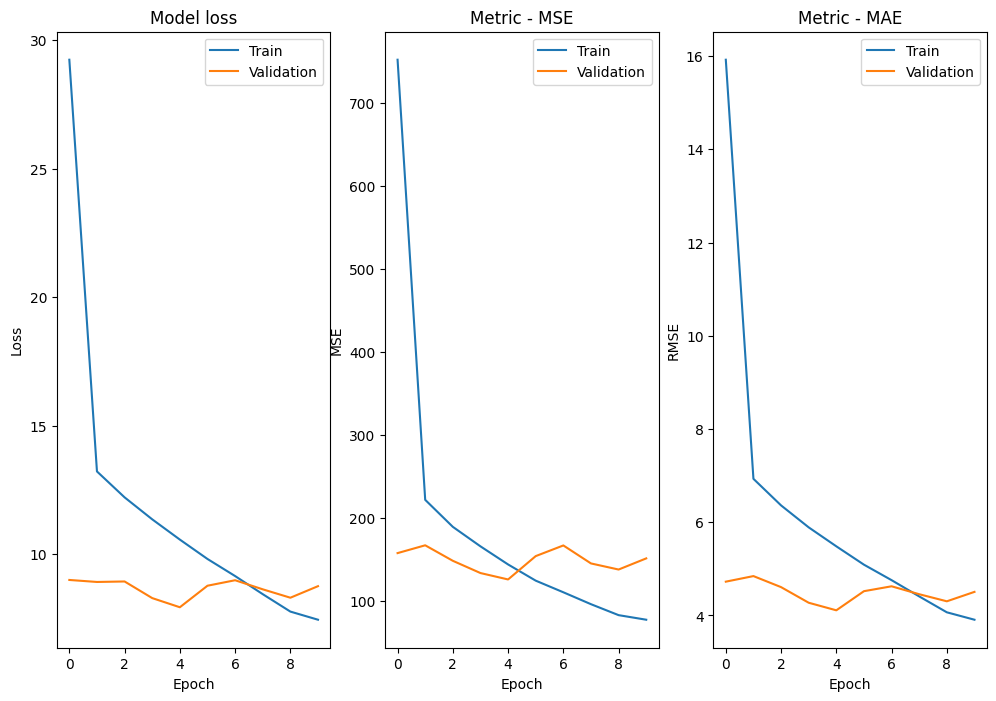

In [44]:
plot_curves(history)

### ***GRU+LSTM Model***

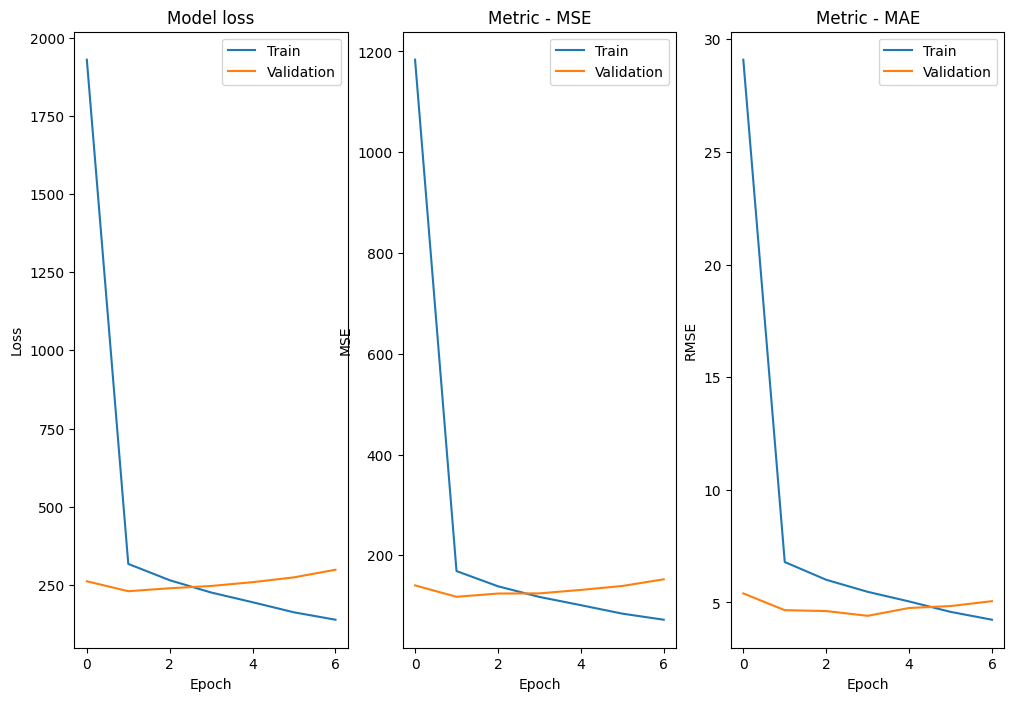

In [66]:
plot_curves(history)

### ***Transformer***

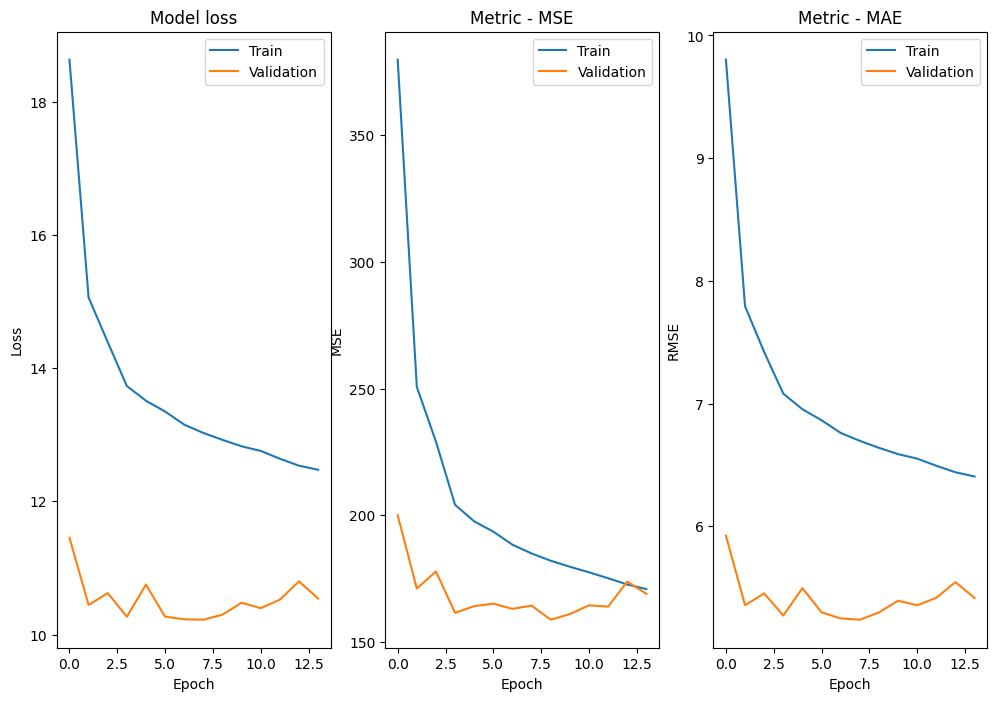

In [54]:
plot_curves(history)

### ***TDNN***

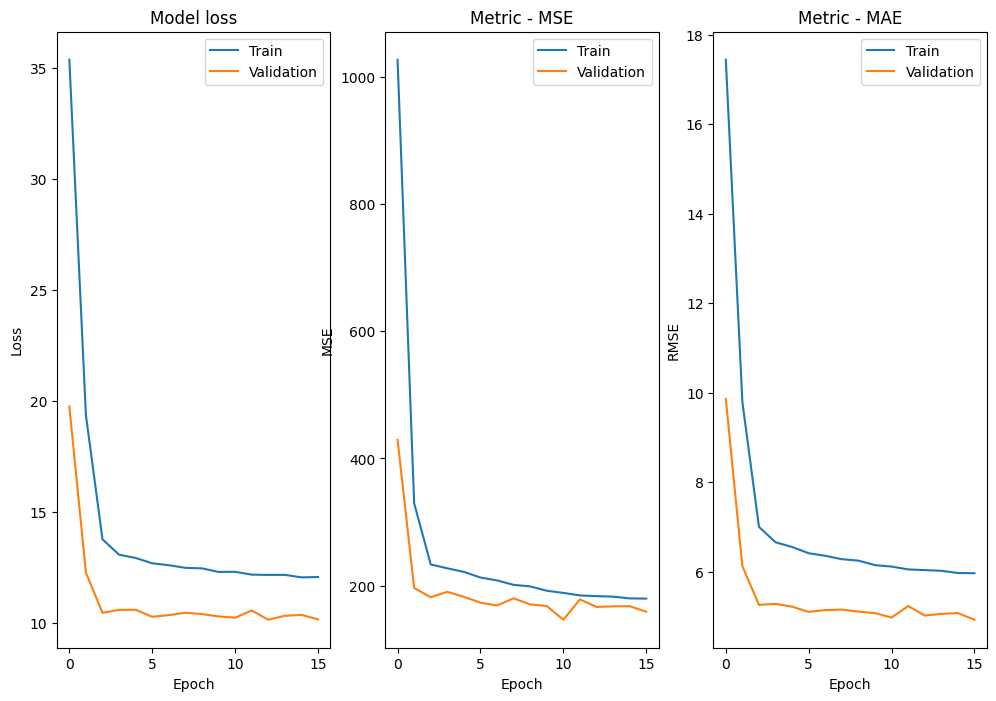

In [57]:
plot_curves(history)

# **Calculating the Weighted Loss**

In [49]:
def weighted_score(model, x, y, metrics):
    y_pred = model.predict(x)
    
    y_true15 = y[:, 0]
    y_true25 = y[:, 1]
    y_true30 = y[:, 2]
    
    y_pred15 = y_pred[:, 0]
    y_pred25 = y_pred[:, 1]
    y_pred30 = y_pred[:, 2]
    
    res = []
    
    for metric in metrics:
        score15 = metric(y_true15, y_pred15)
        score25 = metric(y_true25, y_pred25)    
        score30 = metric(y_true30, y_pred30)
    
        res.append((0.5*score15) + (0.35*score25) + (0.15*score30))
        
    return res

In [50]:
metrics = [r2_score, mean_absolute_error, mean_squared_error]

### ***LSTM Model***

In [47]:
r2score, mae, mse = weighted_score(lstm, x_test, y_test, metrics)

print()
print(f'R2 Score: {r2score}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')

1508/1508 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

R2 Score: 0.8078207975314674
MAE: 4.025232802128672
MSE: 121.13558879543756


### ***GRU+LSTM Model***

In [67]:
r2score, mae, mse = weighted_score(gru_lstm, x_test, y_test, metrics)

print()
print(f'R2 Score: {r2score}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')

3015/3015 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step
0.8801773299879144
0.8583901445693053
0.8456371134083911

4.646055557221684
5.347832493870415
5.747069922848771

121.22766829466815
143.2703225497868
156.17289124710376


R2 Score: 0.8673707826044728
MAE: 5.056829639892803
MSE: 134.18438072682503


### ***Transformer***

In [62]:
r2score, mae, mse = weighted_score(transformer_model, x_test, y_test, metrics)

print()
print(f'R2 Score: {r2score}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')

  99/3015 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step 

W0000 00:00:1718966568.460156     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

R2 Score: 0.8515505095384127
MAE: 4.978571476684864
MSE: 150.1901567238875


### ***TDNN***

In [60]:
r2score, mae, mse = weighted_score(tdnn_model, x_test, y_test, metrics)

print()
print(f'R2 Score: {r2score}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')

  89/3015 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step 

W0000 00:00:1718950800.027453     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

R2 Score: 0.8618257576086501
MAE: 4.845148888303925
MSE: 139.7944247261068


# **Saving the Models**

### ***LSTM***

In [52]:
lstm.save("/kaggle/working/lstm.h5")

### ***GRU+LSTM Model***

In [68]:
gru_lstm.save("/kaggle/working/gru_lstm.h5")

### ***Transformer***

In [63]:
transformer_model.save("/kaggle/working/transformer.keras")

### ***TDNN***

In [61]:
tdnn_model.save("/kaggle/working/tdnn.h5")